In [ ]:
!pip install bertopic
!pip install octis
!pip uninstall gensim -y
!pip install git+https://github.com/RaRe-Technologies/gensim.git@refs/pull/3172/merge

from google.colab import drive
drive.mount("/content/drive", force_remount=True)
import os
os.chdir("/content/drive/My Drive/Evaluation/")

from octis.dataset.dataset import Dataset
from data import DataLoader
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import normalize
from sentence_transformers import SentenceTransformer

In [3]:
import umap
import hdbscan
from bertopic import BERTopic
import tensorflow_hub

from evaluation import Trainer

# Load the data

**Trump_dtm dataset**

In [ ]:
%%time
dataloader = DataLoader(dataset="trump_dtm").prepare_docs(save="trump_dtm.txt").preprocess_octis(output_folder="trump_dtm")

**United Nations dataset**

In [4]:
%%time
dataloader = DataLoader(dataset="un_dtm").prepare_docs(save="un_dtm.txt").preprocess_octis(output_folder="un_dtm")

created vocab
31744
words filtering done
CPU times: user 2min 15s, sys: 4.03 s, total: 2min 19s
Wall time: 2min 31s


In [5]:
%%capture

# Prepare data
#dataset, custom = "trump_dtm", True
dataset, custom = "un_dtm", True
data_loader = DataLoader(dataset)
_, timestamps = data_loader.load_docs()
data = data_loader.load_octis(custom)
data = [" ".join(words) for words in data.get_corpus()]

# Match indices
import os
os.listdir(f"./{dataset}")
with open(f"./{dataset}/indexes.txt") as f:
    indices = f.readlines()
    
indices = [int(index.split("\n")[0]) for index in indices]
timestamps = [timestamp for index, timestamp in enumerate(timestamps) if index in indices]
len(data), len(timestamps)

# Main part

**We start by defining functions that we will use in our code.**

In [6]:
####### c-TF-IDF #######
def c_tf_idf(documents, m, ngram_range=(1, 1)):
  count = CountVectorizer(ngram_range=ngram_range, stop_words="english").fit(documents)
  t = count.transform(documents).toarray()
  w = t.sum(axis=1)
  tf = np.divide(t.T, w)
  sum_t = t.sum(axis=0)
  idf = np.log(np.divide(m, sum_t)).reshape(-1, 1)
  tf_idf = np.multiply(tf, idf)
  return tf_idf, count

def extract_top_n_words_per_topic(tf_idf, count, docs_per_topic, n=20):
  '''
  This function allows us to extract the top n words in a topic
  '''
  words = count.get_feature_names()
  labels = list(docs_per_topic.Topic)
  tf_idf_transposed = tf_idf.T
  indices = tf_idf_transposed.argsort()[:, -n:]
  top_n_words = {label: [(words[j], tf_idf_transposed[i][j]) for j in indices[i]][::-1] for i, label in enumerate(labels)}
  return top_n_words

def extract_topic_sizes(df):
  topic_sizes = (df.groupby(['Topic'])
                      .Doc
                      .count()
                      .reset_index()
                      .rename({"Topic": "Topic", "Doc": "Size"}, axis='columns')
                      .sort_values("Size", ascending=False))
  return topic_sizes

**Main code for dynamic topic modeling visualization**

In [16]:
# We load our document embedder model
embedding_model = tensorflow_hub.load("https://tfhub.dev/google/universal-sentence-encoder/4") # USE is our document embedding model !
topic_model = BERTopic(embedding_model=embedding_model)

/usr/local/lib/python3.7/dist-packages/numba/np/ufunc/parallel.py:363: NumbaWarning: The TBB threading layer requires TBB version 2019.5 or later i.e., TBB_INTERFACE_VERSION >= 11005. Found TBB_INTERFACE_VERSION = 9107. The TBB threading layer is disabled.
  warnings.warn(problem)


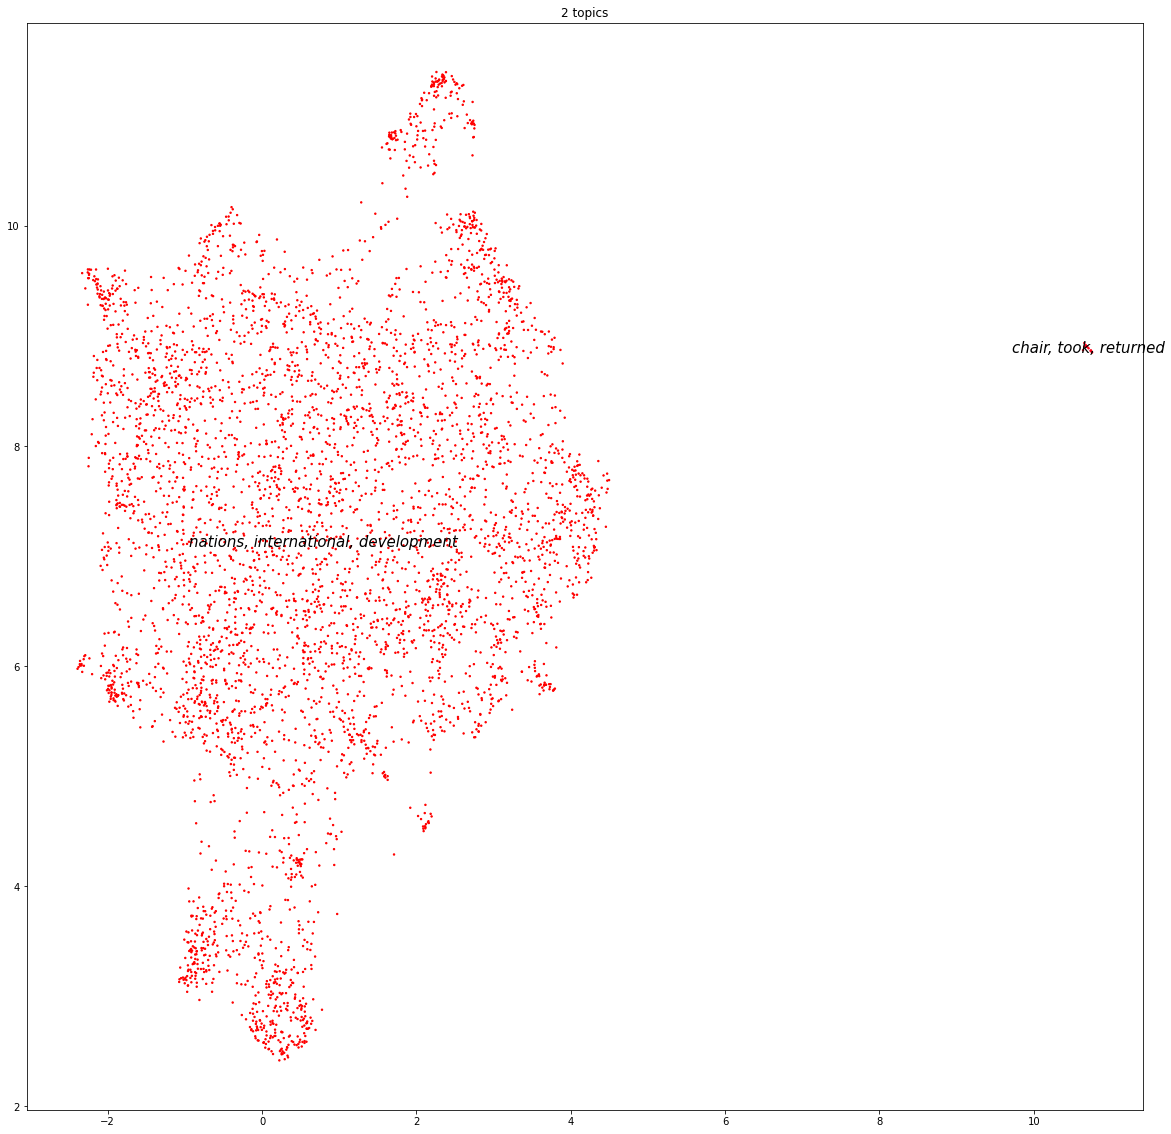

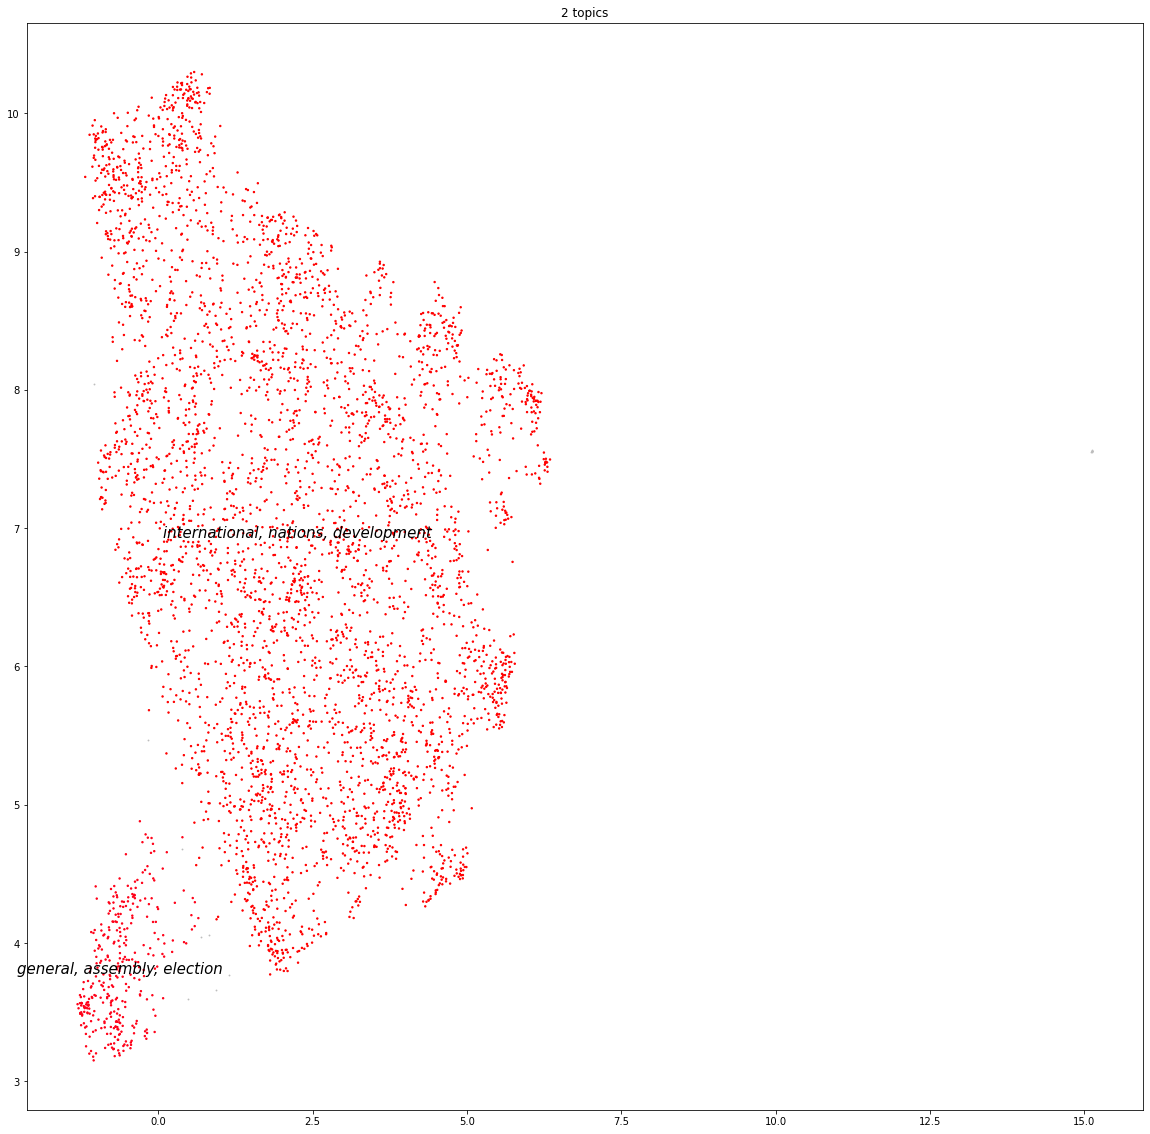

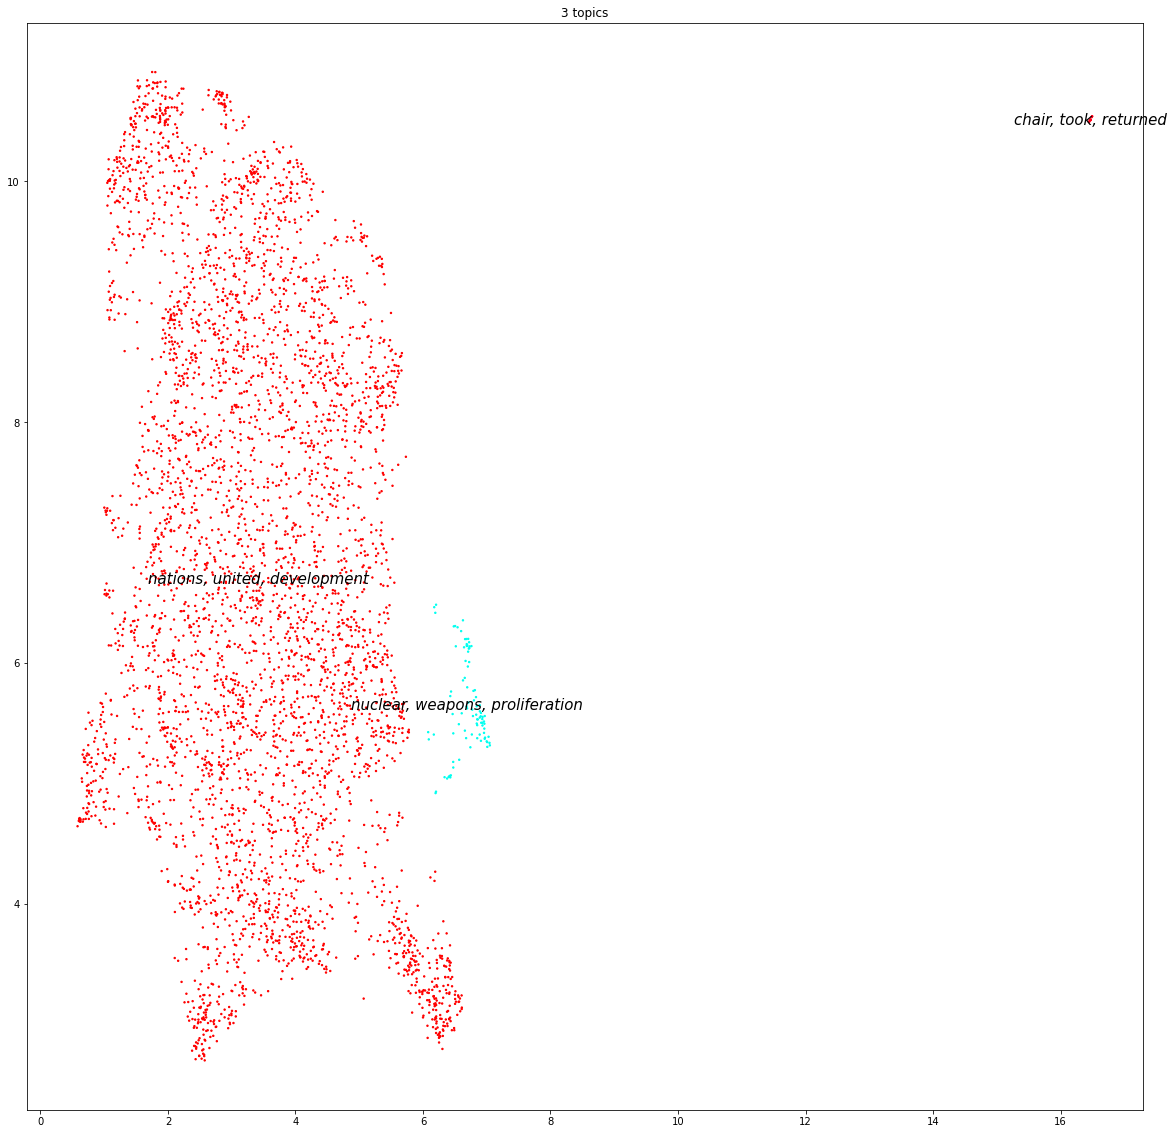

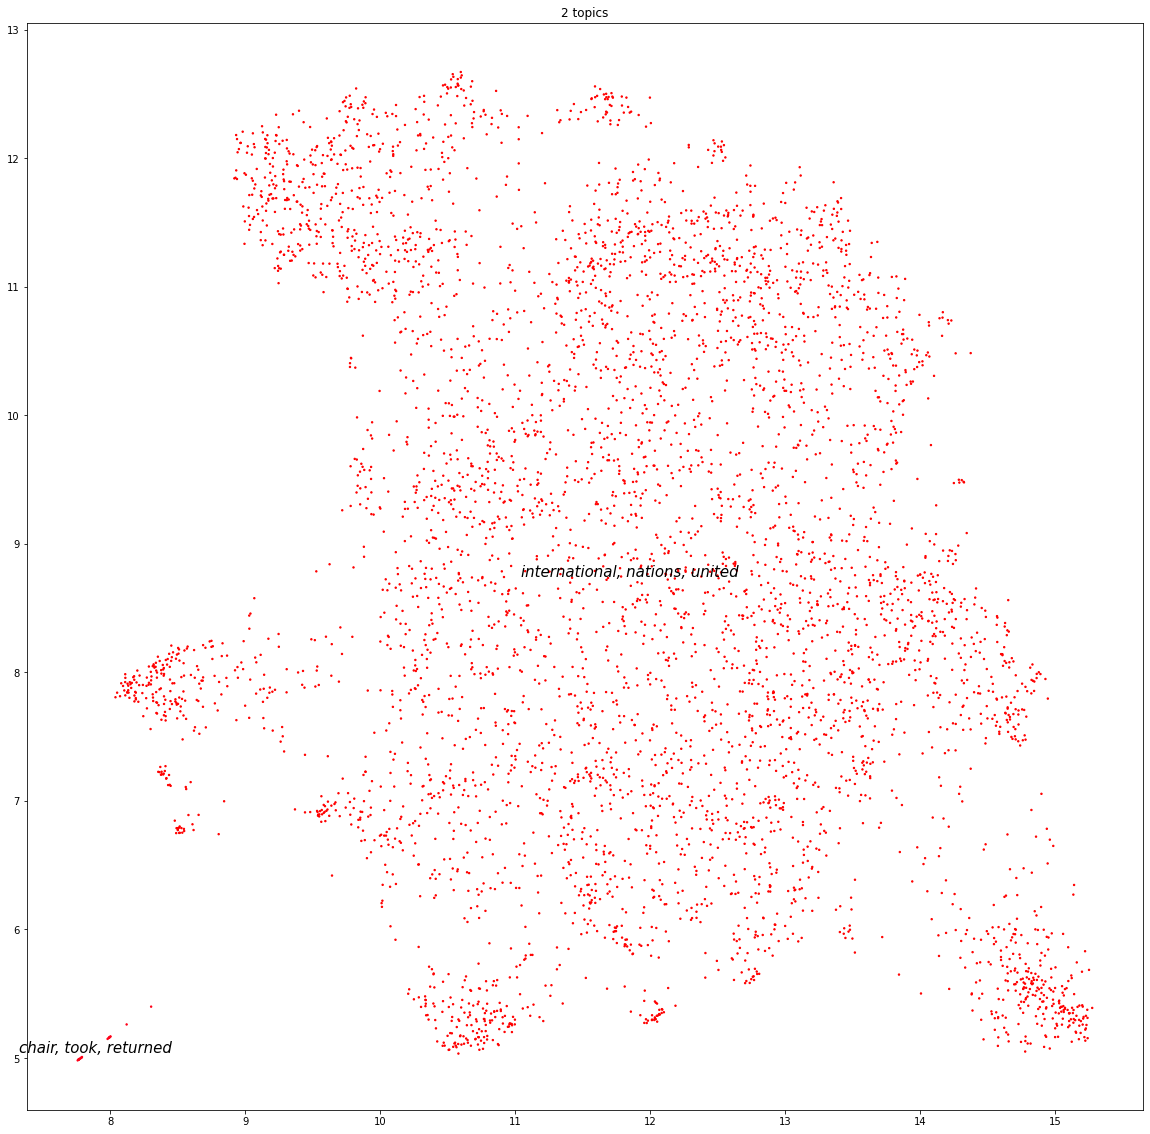

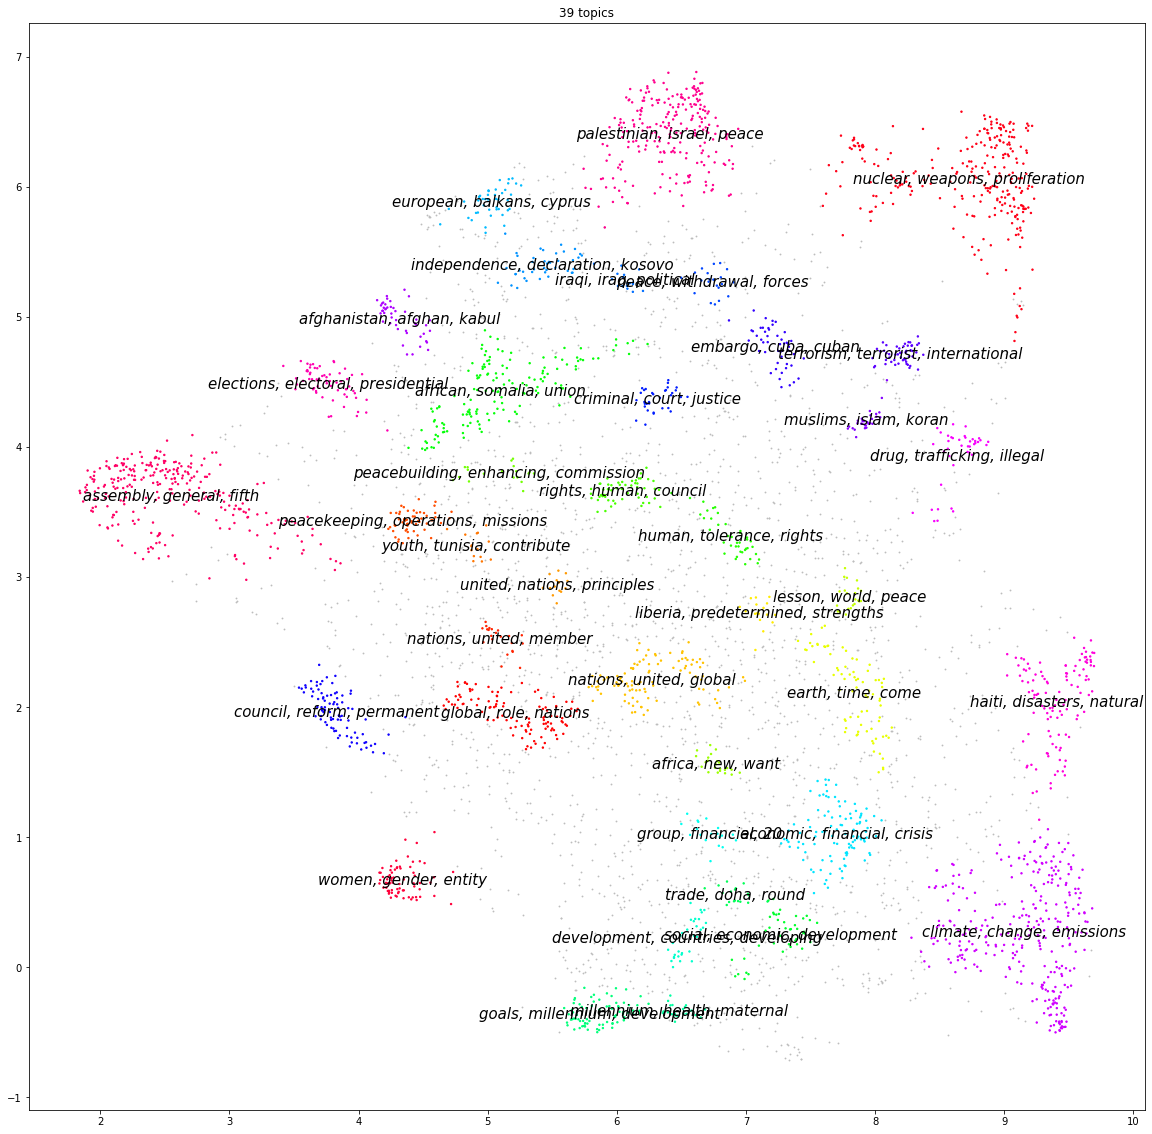

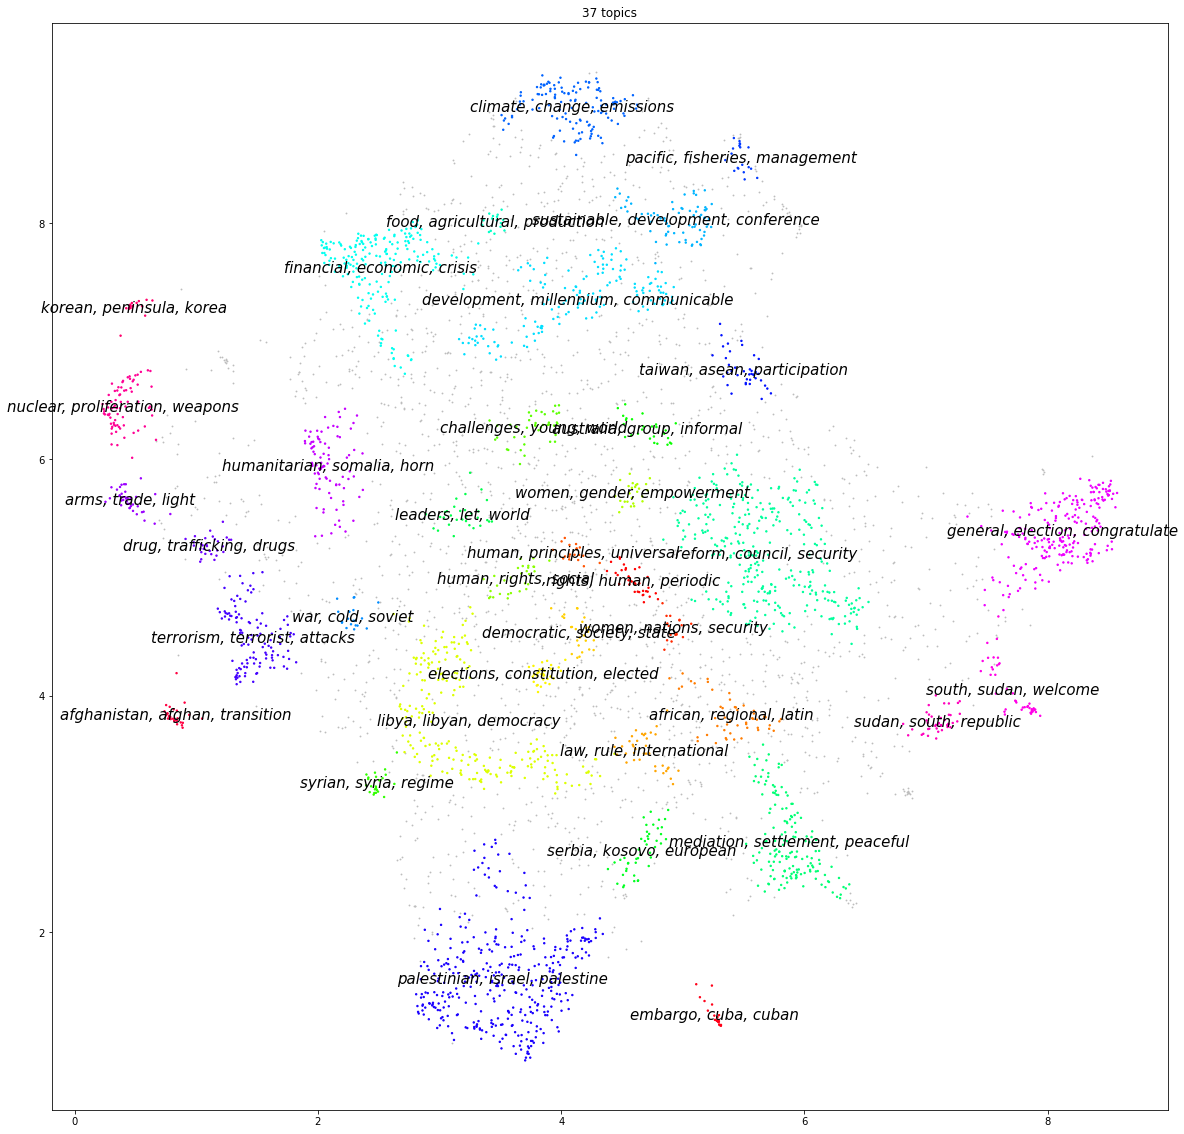

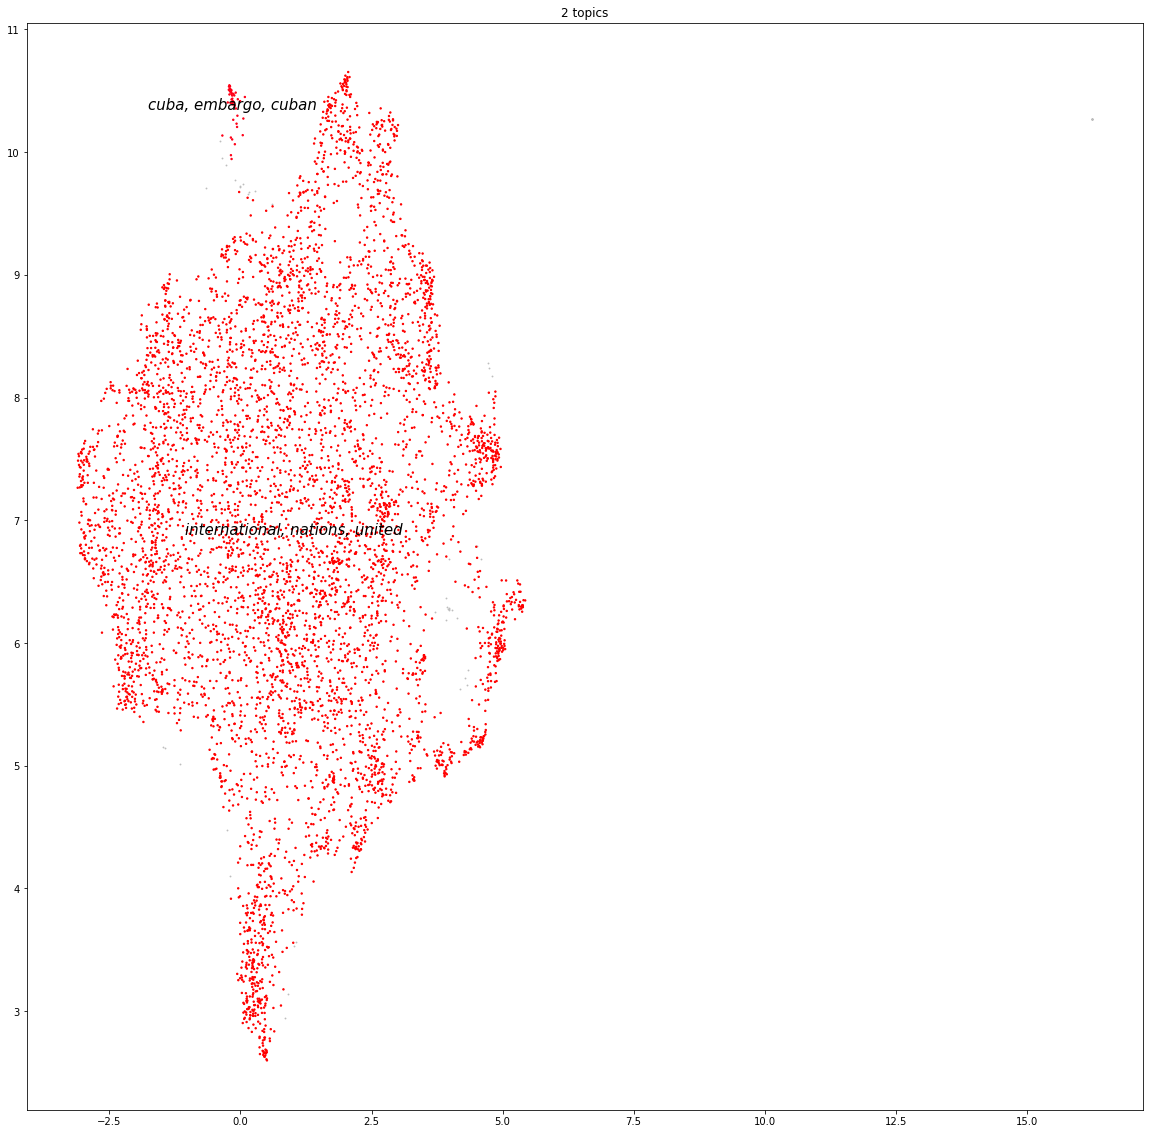

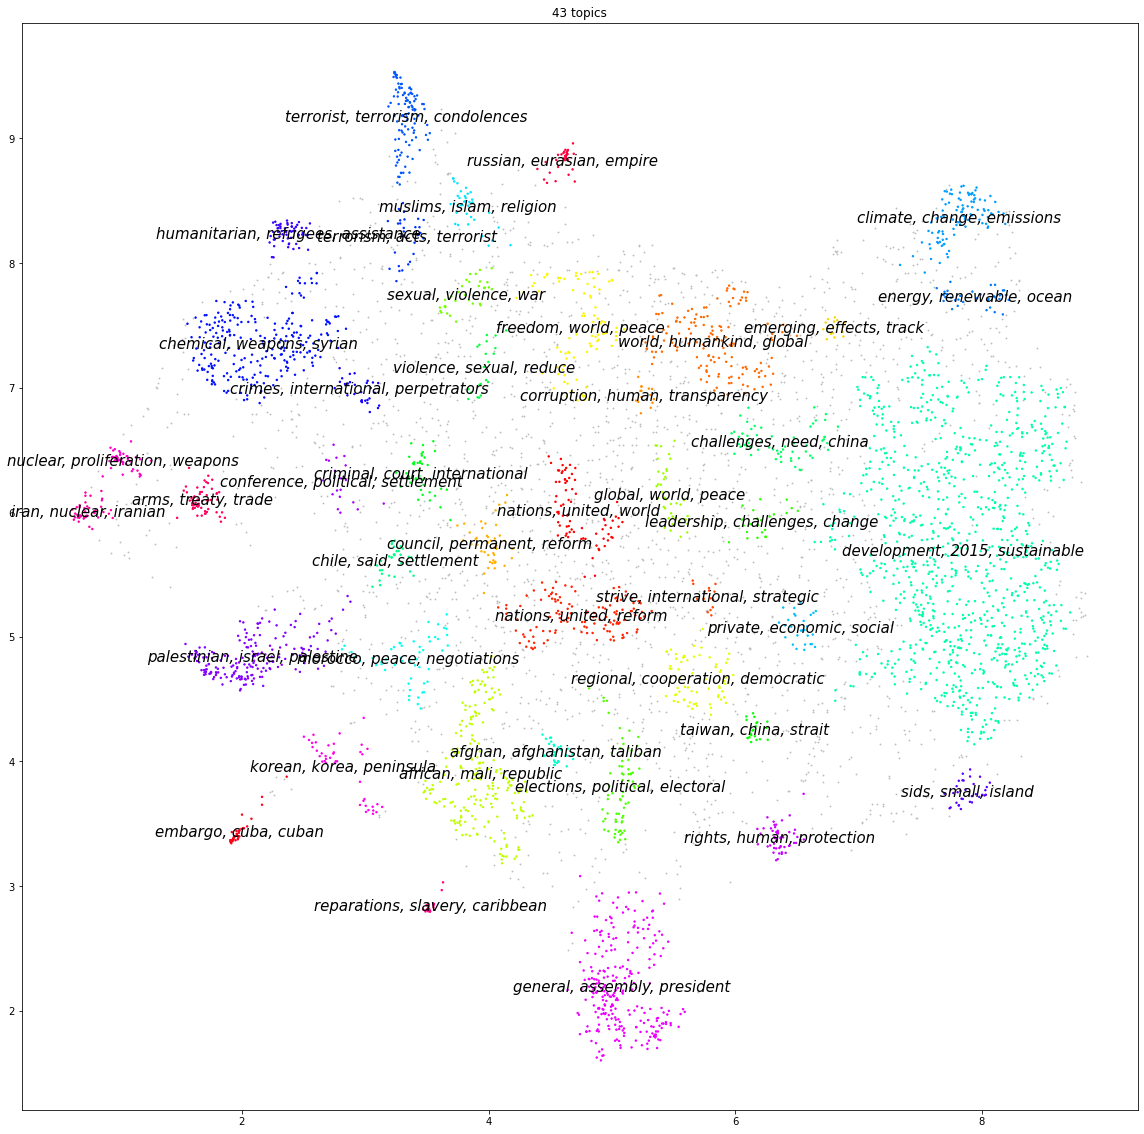

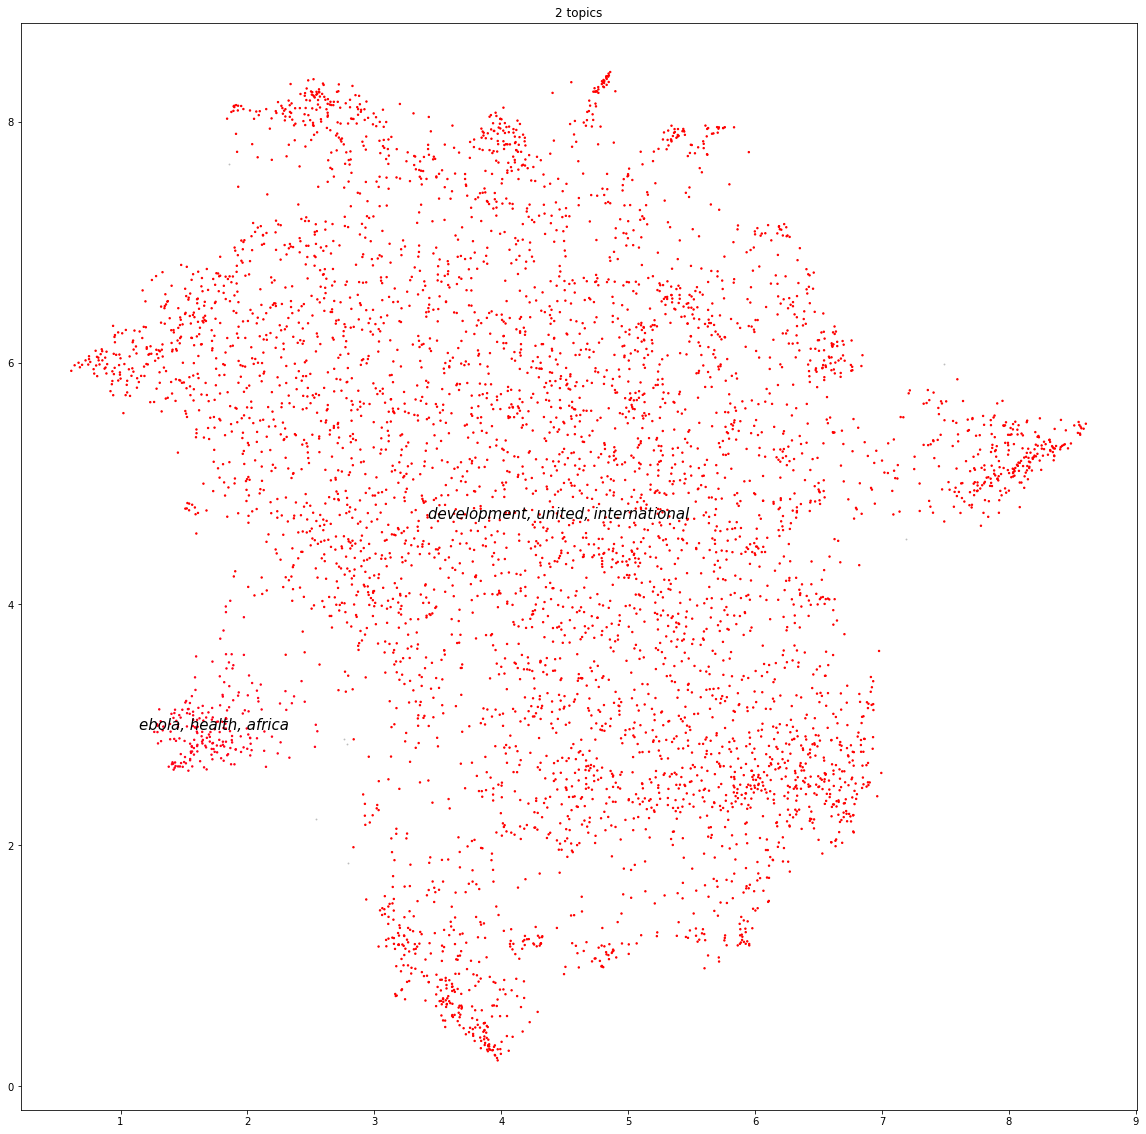

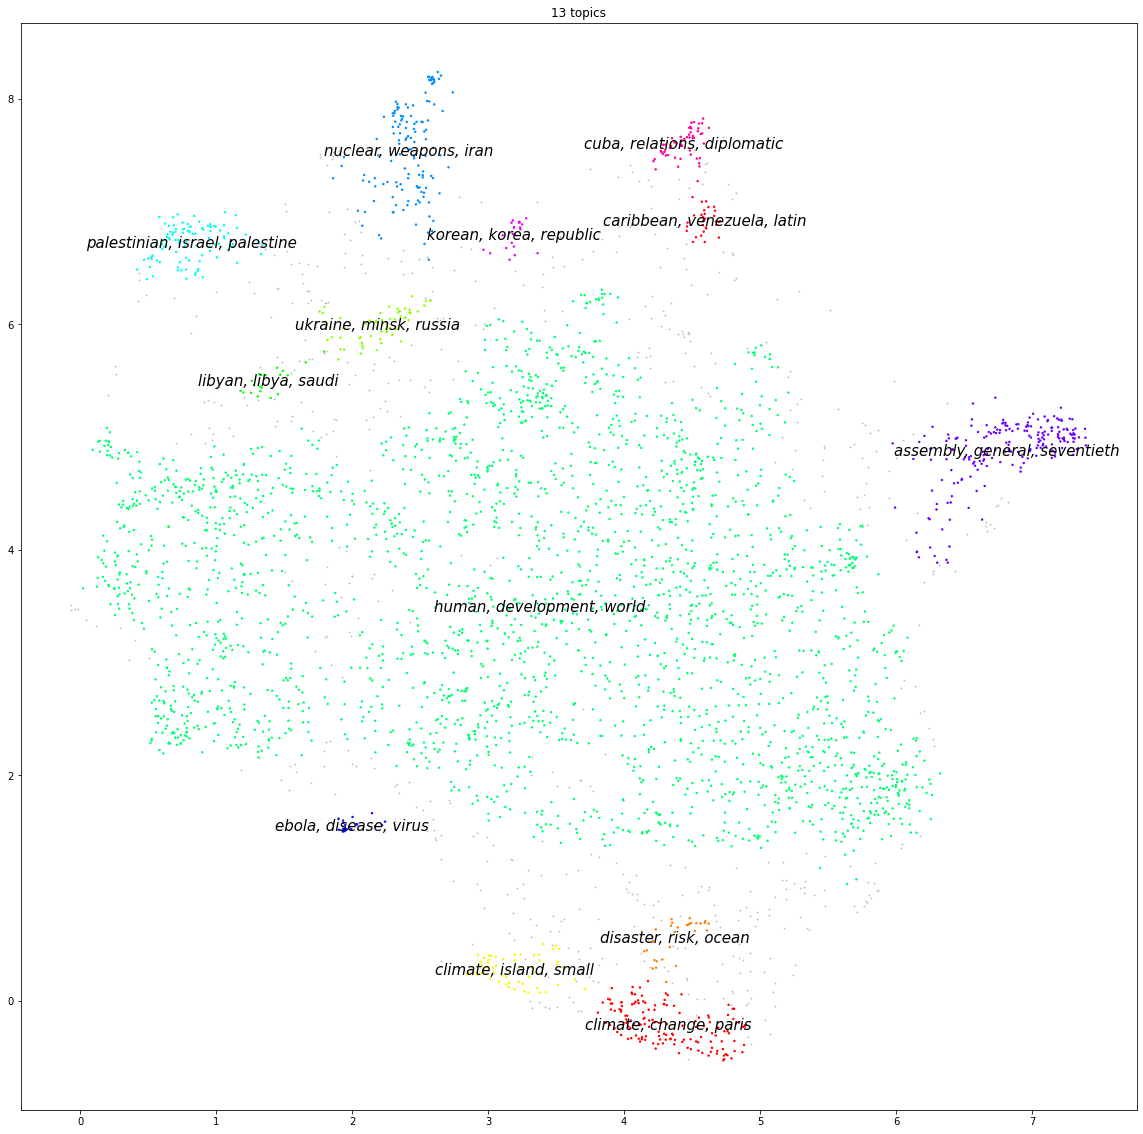

In [18]:
for t in np.unique(timestamps) :
  dataframe = pd.DataFrame(data, columns = ["Doc"])
  dataframe["timestamps"] = timestamps
  DATA = dataframe[dataframe["timestamps"] == t].Doc.values

  ####### Embbed the documents #######
  embeddings = embedding_model(DATA)
  embeddings = np.array(embeddings)

  ####### UMAP (dimension) #######
  umap_args = {'n_neighbors': 15,'n_components': 2,'metric': 'cosine'}
  umap_model = umap.UMAP(**umap_args).fit(embeddings)
  umap_model = umap_model.fit(embeddings)
  umap_embeddings = umap_model.transform(embeddings)

  ####### HDBSCAN (clustering) #######
  hdbscan_args = {'min_cluster_size': 15, 'metric': 'euclidean', 'cluster_selection_method': 'eom'} #'min_cluster_size': 15 is the standard value in HDBSCAN
  cluster = hdbscan.HDBSCAN(**hdbscan_args).fit(umap_embeddings)
  #To look at the clusters found by the algorithm, we just need to run "cluster.labels_" or "np.unique(cluster.labels_)"

  # We create a dataframe for the visualization part
  result = pd.DataFrame(umap_embeddings, columns=['x', 'y'])
  result['labels'] = cluster.labels_
  result["text"] = DATA

  ########### c-TF-IDF #############
  '''
  Now, we are going to compute the c-TF-IDF value of each word. The function c-tf-idf has been implemented earlier in 
  the code. 
  We start by creating a dataframe "docs_df" to facilitate the computation of c-TF-IDF.
  '''
  docs_df = pd.DataFrame(DATA, columns=["Doc"])
  docs_df['Topic'] = cluster.labels_
  docs_df['Doc_ID'] = range(len(docs_df))
  docs_per_topic = docs_df.groupby(['Topic'], as_index = False).agg({'Doc': ' '.join})

  ####### c-TF-IDF #######
  tf_idf, count = c_tf_idf(docs_per_topic.Doc.values, m=len(DATA))
  # N.B. : "tf-idf" contains the c-TF-IDF values. Hence, we have a single importance value for each word in a cluster *

  ####### Topic representation #######
  top_n_words = extract_top_n_words_per_topic(tf_idf, count, docs_per_topic, n=10)
  topic_sizes = extract_topic_sizes(docs_df); topic_sizes.head(10)

  ####### Plot #######
  '''
  In order to display the words along with the clusters (topics), we need to calculate the topic vectors.
  '''
  unique_labels = set(cluster.labels_)
  # Since topic -1 refers to outliers/noises, we need to remove the noise and work with the "real" topics 
  if -1 in unique_labels:
    unique_labels.remove(-1)

  topic_vectors = np.array([result[result["labels"]== label][["x","y"]].mean() for label in unique_labels])

  # We concatenate the three first words of each topic (for the plot)
  topics = [top_n_words[i][0][0]+", "+top_n_words[i][1][0]+", "+top_n_words[i][2][0] for i in range(len(topic_vectors))]

  # We create a dataframe for the visualization
  result = pd.DataFrame(umap_embeddings, columns=['x', 'y'])
  result['labels'] = cluster.labels_
  result["text"] = DATA # We need to change d2006

  # Visualize 2Dembeddings + Topics
  fig, ax = plt.subplots(figsize=(20, 20))
  outliers = result.loc[result.labels == -1, :]
  clustered = result.loc[result.labels != -1, :]
  plt.scatter(outliers.x, outliers.y, color='#BDBDBD', s=0.7)
  plt.scatter(clustered.x, clustered.y, c=clustered.labels, s=2,cmap='hsv_r')
  for i in range(len(topic_vectors)) :
    plt.text(topic_vectors[i][0], topic_vectors[i][1], topics[i]
            ,horizontalalignment='center', verticalalignment='center'
            ,fontsize=15, style = 'oblique') #  bbox={'facecolor': 'red', 'alpha': 0.5, 'pad': 10}
  #plt.xlim(0,15)
  #plt.ylim(0,15)
  plt.title(f"{len(unique_labels)} topics")
  #plt.colorbar()
